In [1]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [2]:
path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\cluster_zeta_0.022'
d_cluster = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\cluster_zeta_0.022', \
              suffix = "cluster", priority = -1, LX = 512, Nframes = 1500)
output_path = 'data\\nematic_analysis512_LL0.05\\cluster' 
if not os.path.exists(output_path):
    os.makedirs(output_path)

rm_list = []
for i, file in enumerate(os.listdir(os.path.join(path, os.listdir(path)[0]))):
    if file.startswith('labels'):
        rm_list.append(int(file.split('rm')[-1].split('.')[0]))


In [8]:

rm_list = []

Nclusters = 250
Ncmin = 1
Nframes = 1501
Ndefects = 0
for i, input in enumerate(os.listdir(d_cluster['path'])):
    path = os.path.join(d_cluster['path'], input)
    if i == 0:

        print(f'Analyzing {input}')
        # Load data
        
        for file in os.listdir(path):
            if file.startswith('labels'):
                rm = int(file.split('rm')[-1].split('.')[0])
                if 2 < rm < 150:
                    rm_list.append(int(file.split('rm')[-1].split('.')[0]))

        cluster_arr = np.nan * np.zeros([Nframes, Nclusters - Ncmin, len(rm_list), len(os.listdir(d_cluster['path']))])
        num_clusters = np.zeros([Nframes, len(rm_list), len(os.listdir(d_cluster['path']))])

    with open(os.path.join(path, 'defect_positions.pkl'), 'rb') as f:
        defect_positions = pickle.load(f)

    for k, dist in enumerate(rm_list):
        with open(os.path.join(path, f'labels_rm{dist}.pkl'), 'rb') as f:
            labels = pickle.load(f)
        for j, frame in enumerate(labels):

            if k == 0:
                Ndefects += len(defect_positions[j])

            unique, counts = np.unique(frame, return_counts=True)
            valid_clusters_mask = (counts >= Ncmin)
            num_clusters[j, k, i] = len(unique[valid_clusters_mask])

            # count the number of clusters of each size
            cluster_sizes, cluster_counts = np.unique(counts[valid_clusters_mask], return_counts=True)

            cutoff_mask = (cluster_sizes > Nclusters - 1)
            count_upper  = cutoff_mask.sum()

            cluster_arr[j, cluster_sizes[~cutoff_mask], k, i] = cluster_counts[~cutoff_mask]
            cluster_arr[j, -1, k, i] = count_upper


cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
cluster_arr_std = np.nanstd(cluster_arr, axis = (0,-1)) #/ np.sqrt(cluster_arr.shape[0]*cluster_arr.shape[1])

num_cluster_av = np.mean(num_clusters, axis = (0,-1))
num_cluster_std = np.std(num_clusters, axis = (0,-1))/np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])

Analyzing zeta_0.022_counter_0


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14028\1043818220.py:48: RuntimeWarning: Mean of empty slice
  cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
Nupper = 100 - Ncmin

ff = 0

Nmembers_arr = np.nansum(cluster_arr[ff:, :, :, :], axis=(0,-1)) * np.arange(Ncmin, Nclusters)[:, None] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_above = Nmembers_arr[Nupper:,:].sum(axis = 0)
Nmembers_arr = Nmembers_arr[:Nupper,:] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_arr[Nupper - 1,:] += Nmembers_above

10 -10 120
10 0 150
10 0 35


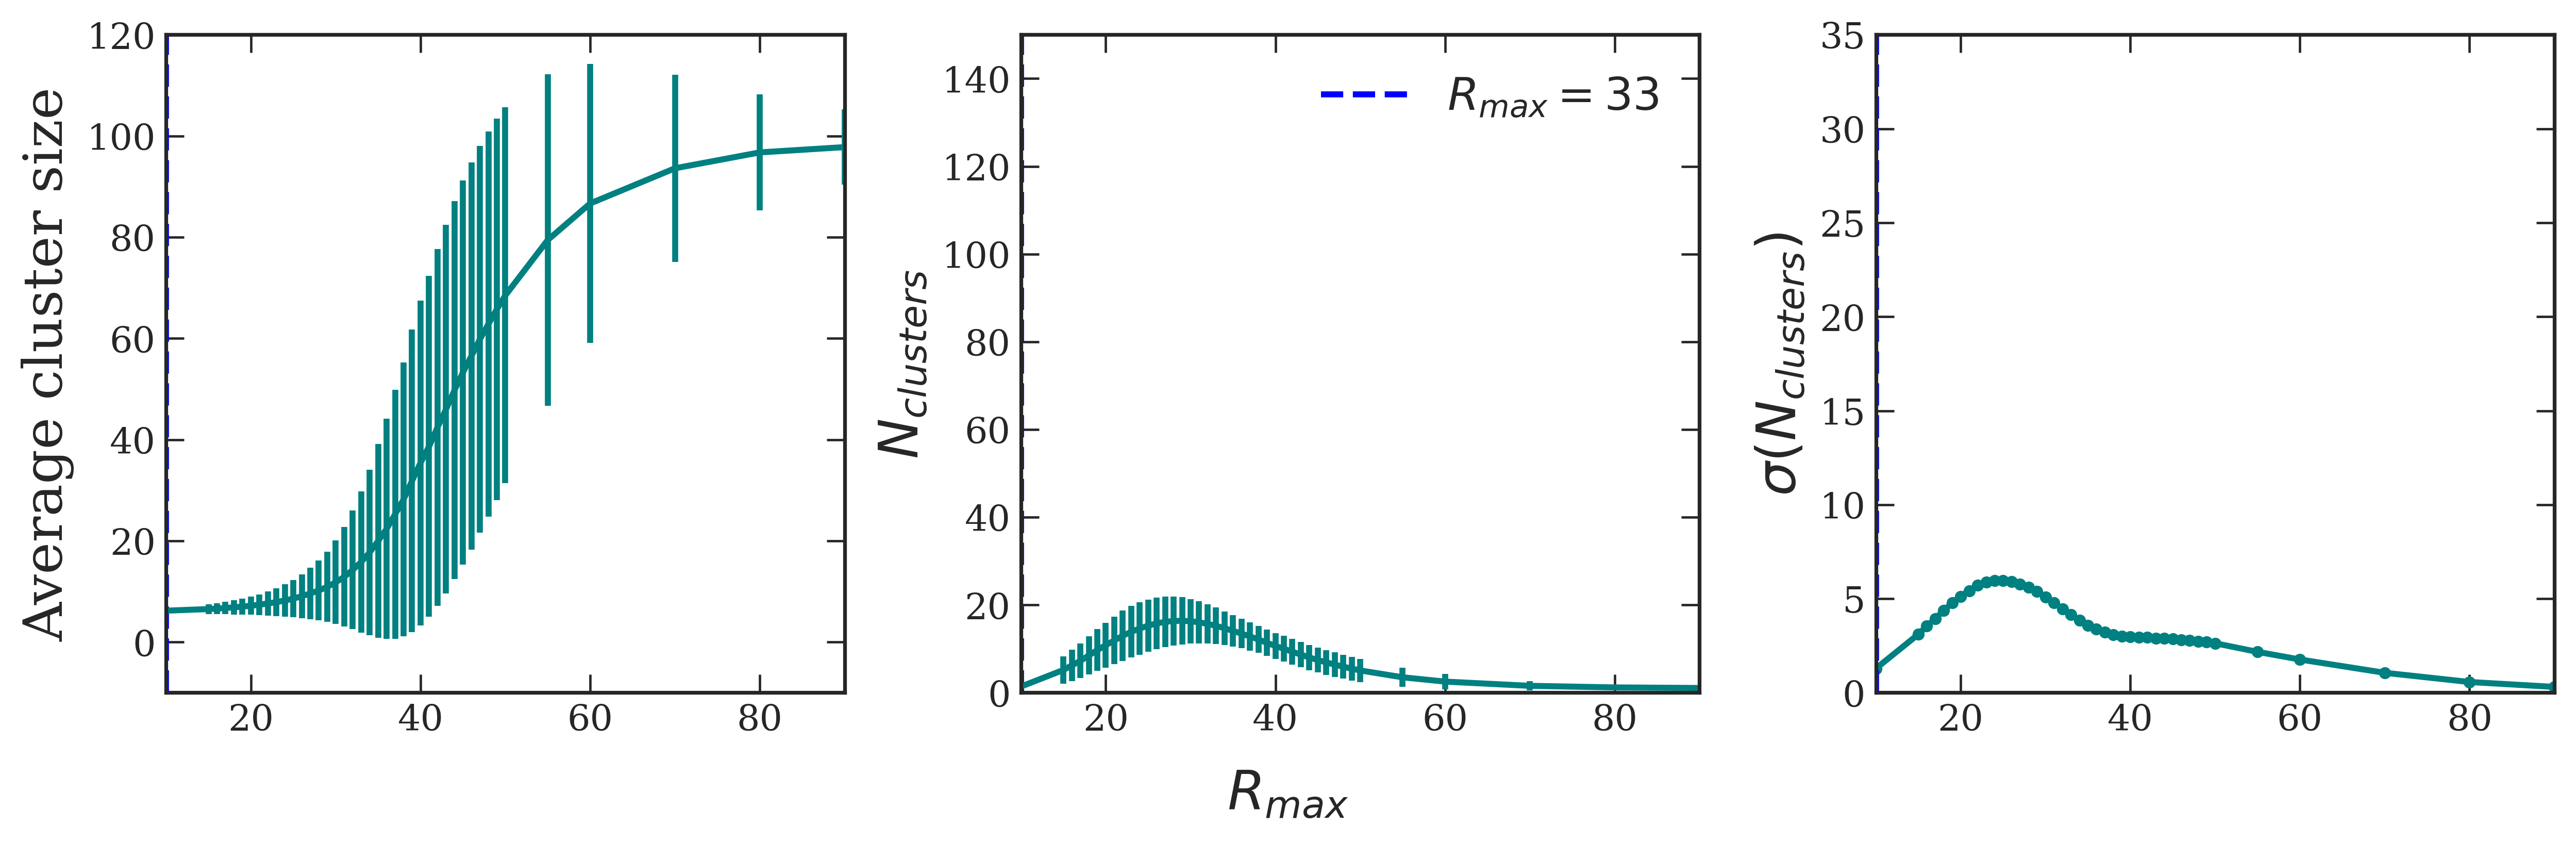

In [12]:
fig, ax = plt.subplots(nrows = 1,ncols=3, figsize=(12, 4))
ax = ax.flatten()
Nmembers = Nmembers_arr[:, :] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin) [:, None]
av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)[:,None], axis=0) / Nmembers.sum(axis=0)
std_cluster_size = np.sqrt(np.sum(Nmembers * ((np.arange(Ncmin, Nupper + Ncmin)[:,None] - av_cluster_size[None,:])**2), axis=0)\
                            / Nmembers.sum(axis=0),)


dy = np.diff(av_cluster_size)
dx = np.diff(rm_list)
nc_std = num_cluster_std *np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])
min_idx = np.argwhere(np.diff(nc_std) > 0)[0][0] 


ax[0].errorbar(rm_list, av_cluster_size, std_cluster_size, label = 'Average cluster size')
ax[1].errorbar(rm_list, num_cluster_av, nc_std,)
ax[2].plot(rm_list, nc_std, '.-')


fig.supxlabel(r'$R_{max}$', y=0.04)
m_list = [120, 150, 35]
ylim_list = [(-10,120), (0, 150), (0, 35)]
ylabel_list = ['Average cluster size', r'$N_{clusters}$', r'$\sigma(N_{clusters})$']

for j, axx in enumerate(ax):
    axx.set_ylim(ylim_list[j])
    axx.set_xlim([10,90])
    axx.set_ylabel(ylabel_list[j])
    axx.set_xticks(np.arange(20,100,20), np.arange(20,100,20))
    print(rm_list[min_idx], ylim_list[j][0], m_list[j])
    axx.vlines(rm_list[min_idx], ylim_list[j][0], m_list[j], label = r'$R_{max} = 33$', linestyles = 'dashed', color = 'b')
ax[1].legend()

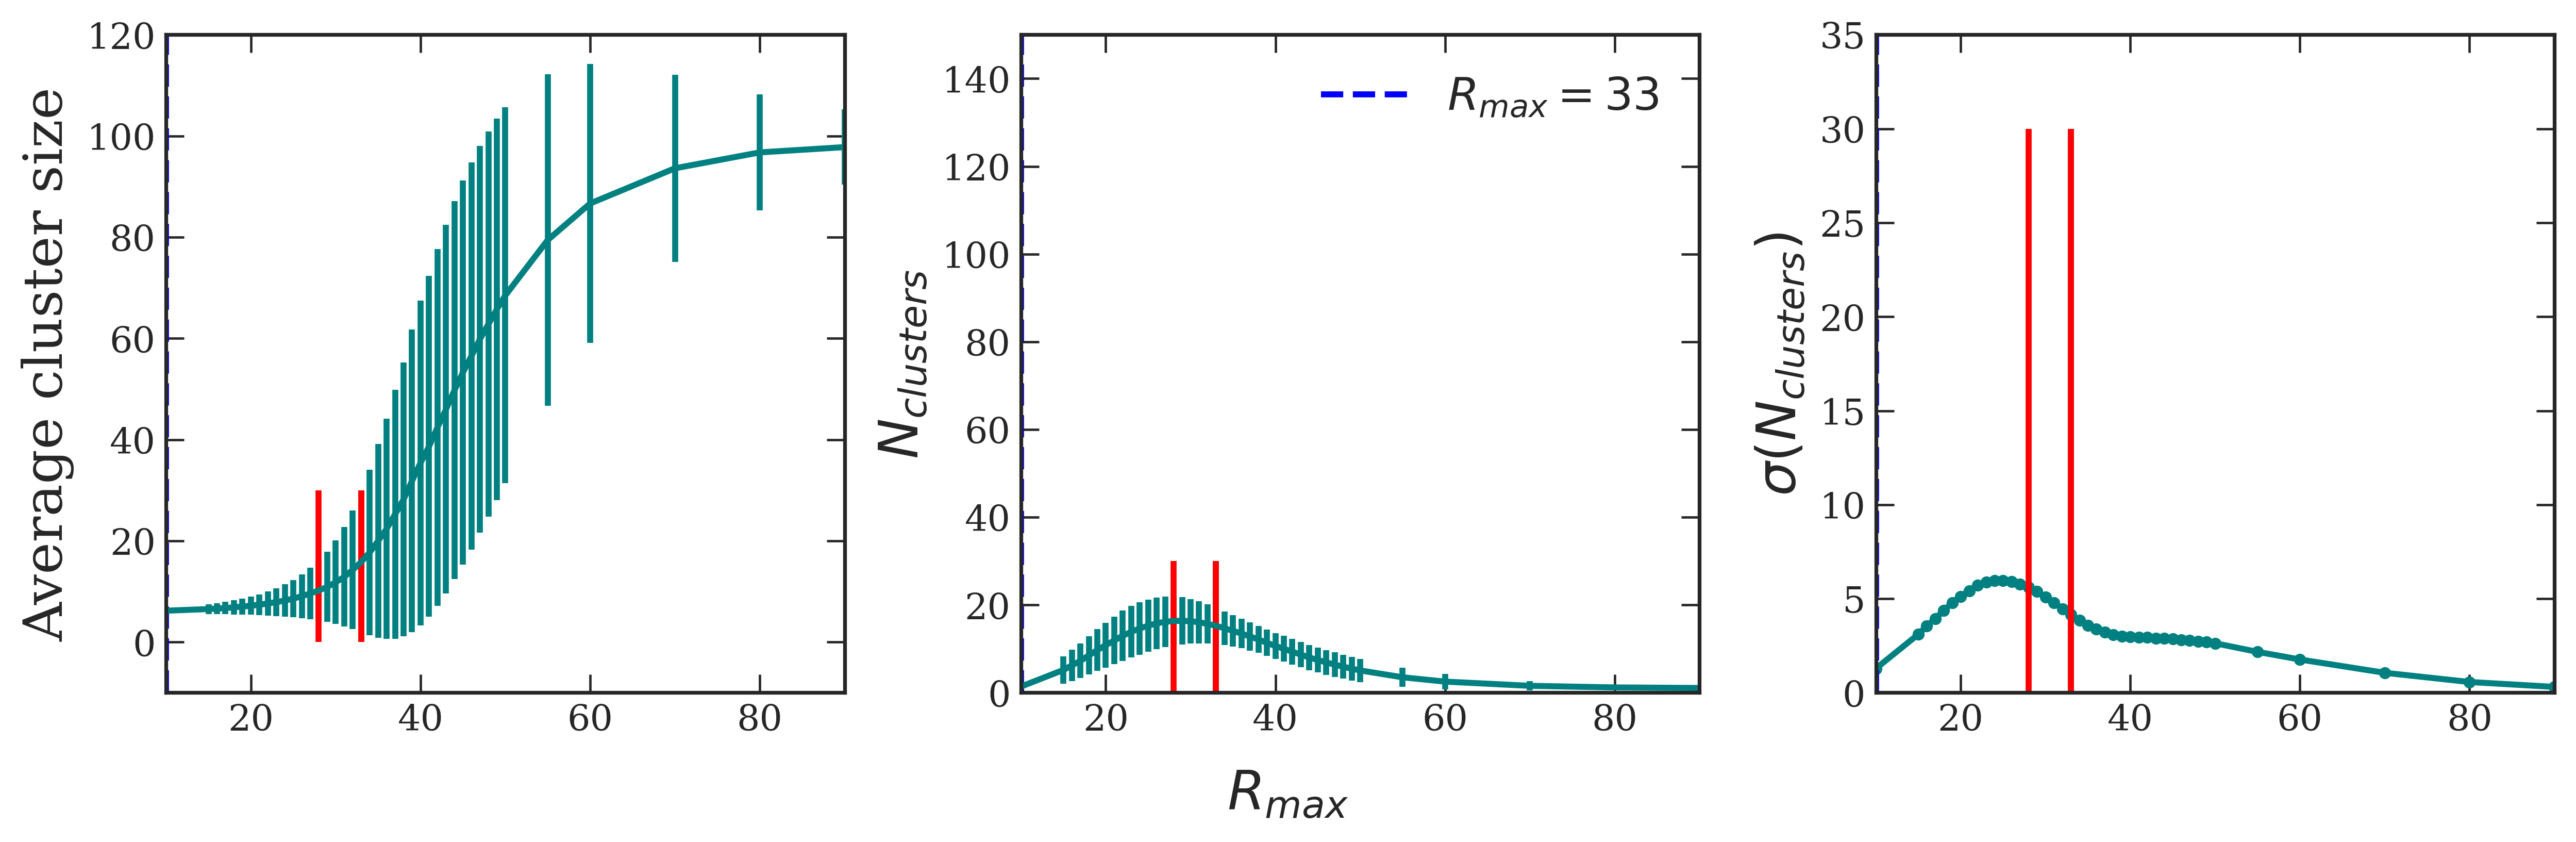

In [16]:
for i, axx in enumerate(ax):
    axx.vlines(28,0,30, color='red')
fig

In [37]:
Ncmin

3

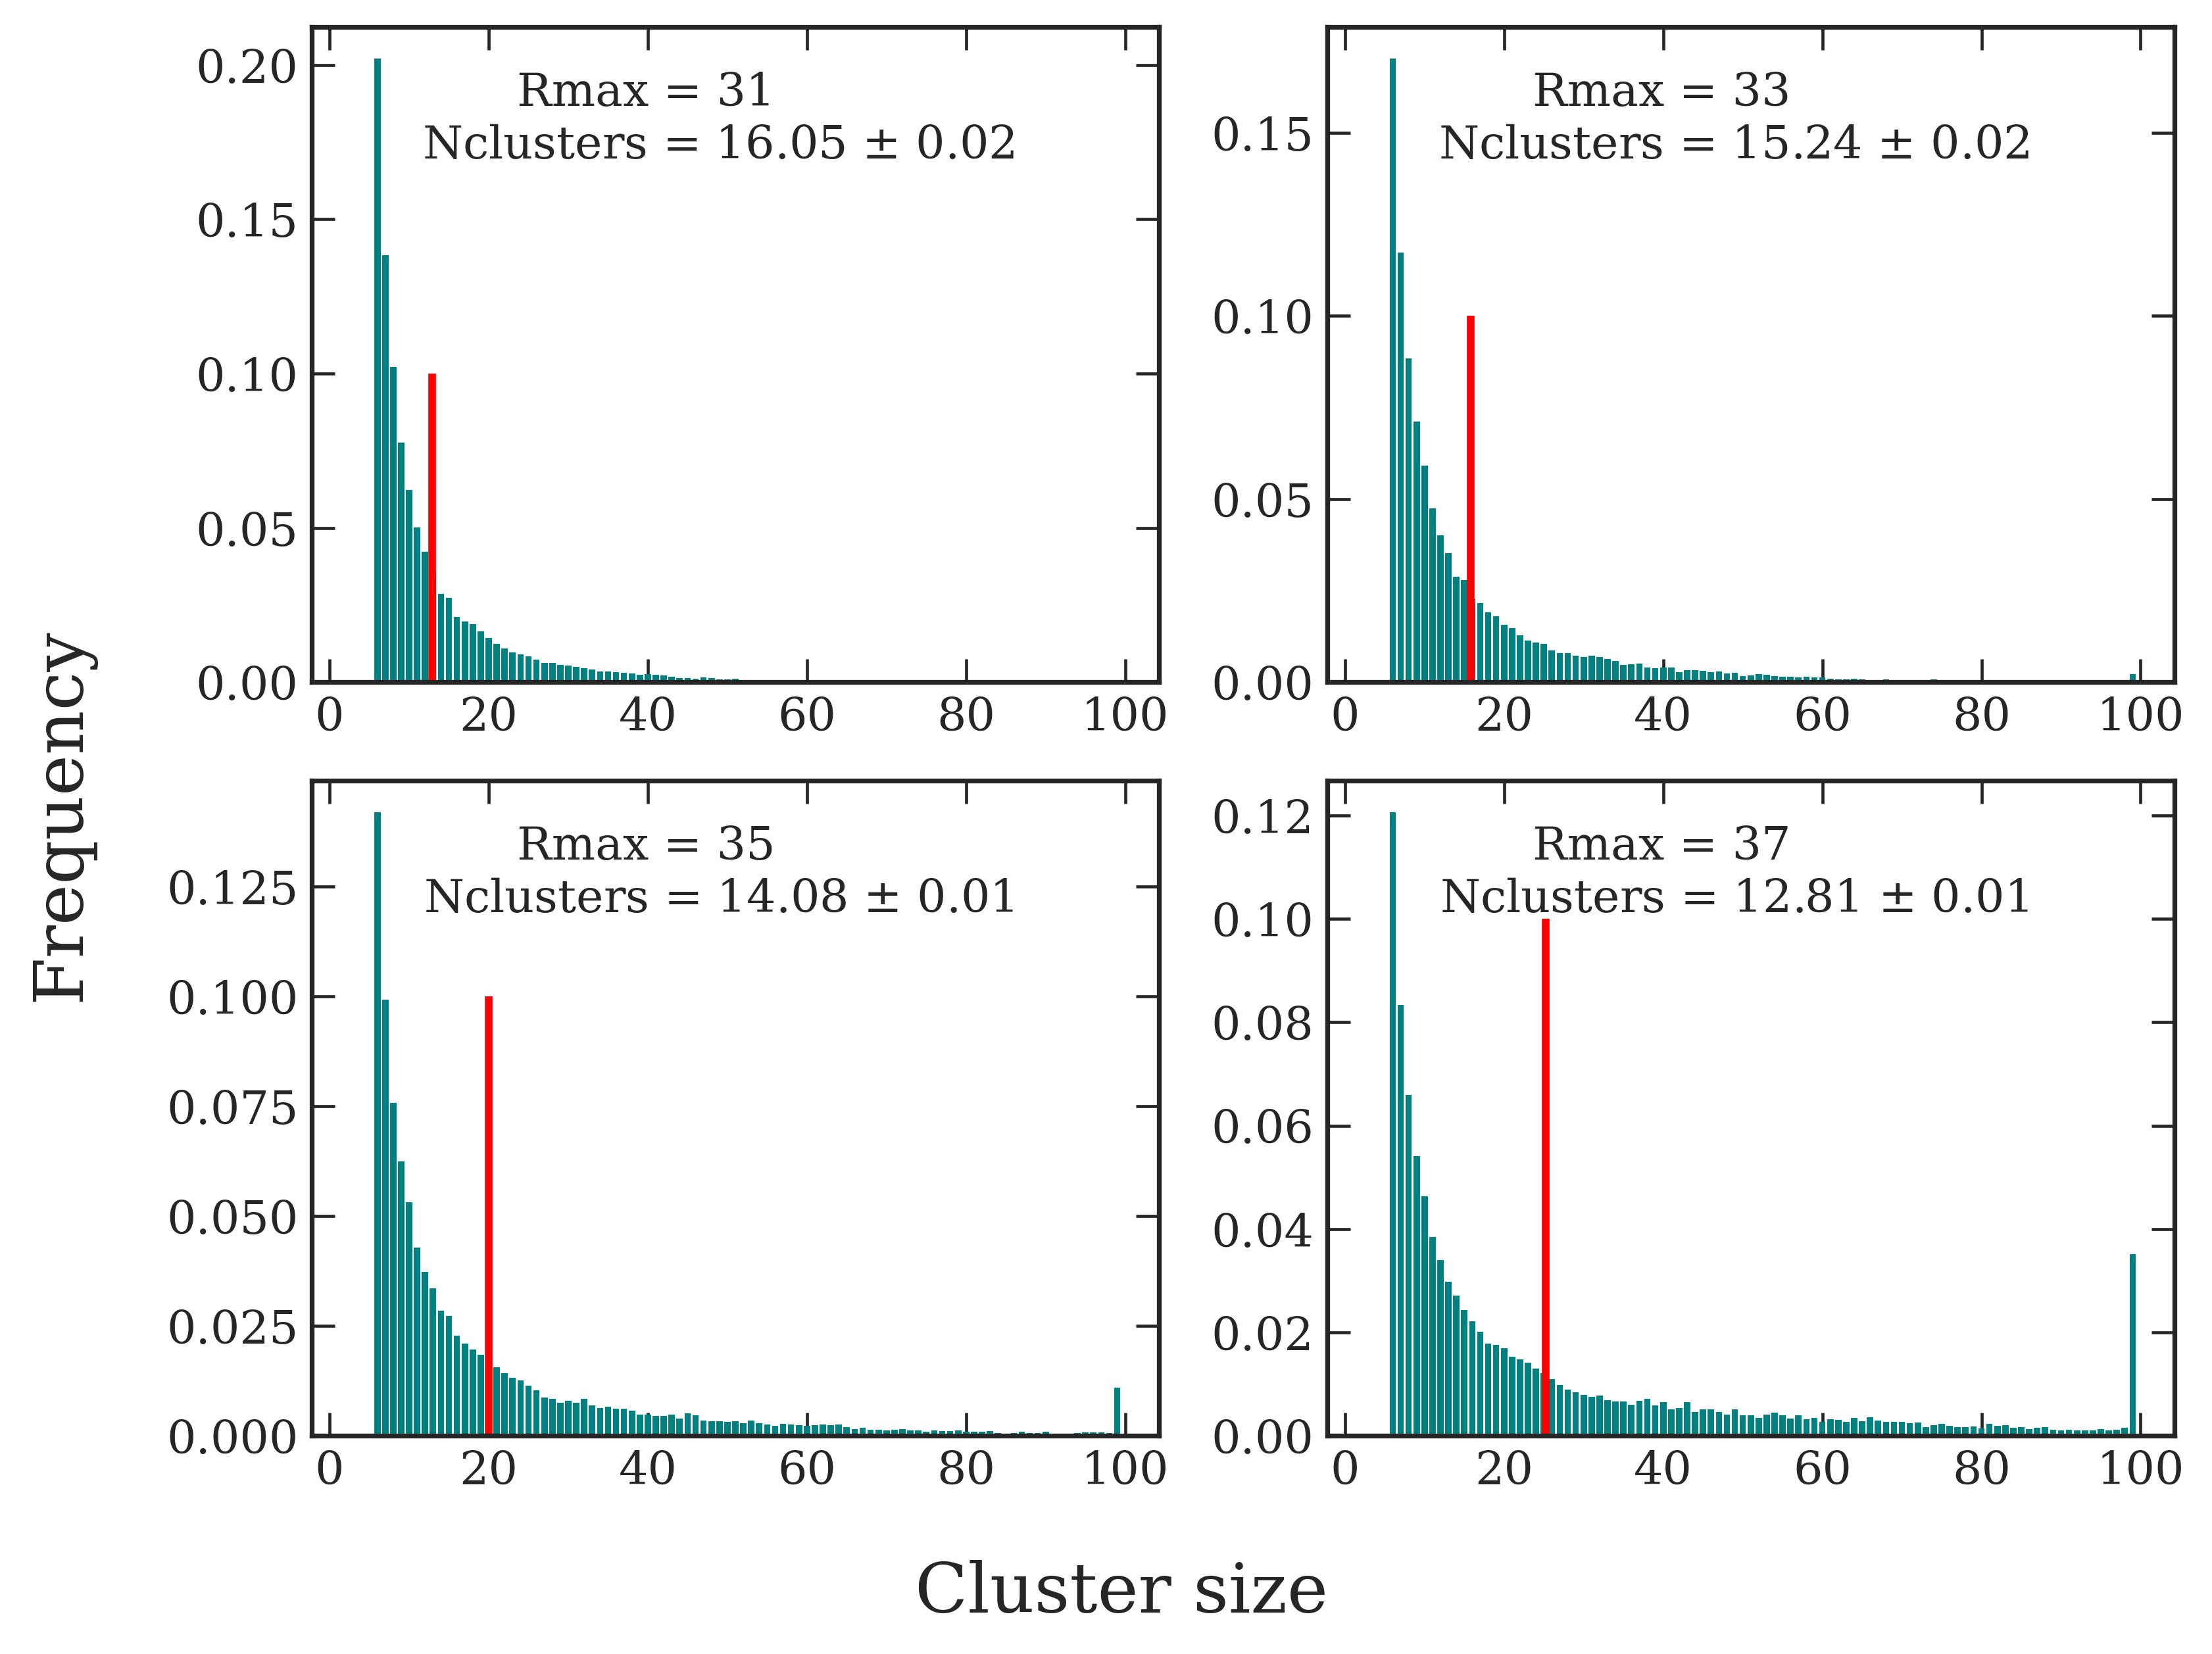

In [36]:
ncols = 2
rm_res = rm_list[16:28]

rm_res = [31, 33, 35, 37]
nrows = int(np.ceil(len(rm_res)/ncols))


fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(8, 6))
ax = ax.flatten()
for i, dist in enumerate(rm_res):
    idx = rm_list.index(dist)

    Nmembers = Nmembers_arr[:, idx] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

    cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin)
    av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)) / Nmembers.sum()
    std_cluster_size = np.sqrt(np.sum(Nmembers * (np.arange(Ncmin, Nupper + Ncmin) - av_cluster_size)**2) / Nmembers.sum())
    
  
    ax[i].vlines(av_cluster_size, 0, .1, color = 'r')
   # ax[i].vlines(av_cluster_size + std_cluster_size, 0, 2e5, color = 'r', linestyle = '--')
   # ax[i].vlines(av_cluster_size - std_cluster_size, 0, 2e5, color = 'r', linestyle = '--')
    ax[i].bar(np.arange(Ncmin, Nupper + Ncmin), Nmembers / Nmembers.sum()) #, yerr = cluster_arr_std[:,idx],)
   # ax[i].set_title(f'Rmax = {dist}')
    #ax[i].hist(cluster_arr[:,:,idx,:].flatten(), bins = 100, range = (1,106));
    
    ax[i].text(0.48, 0.82, f'Nclusters = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}', \
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)
    ax[i].text(0.395, 0.9, f'Rmax = {dist}', \
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)
  #  ax[i].set_xticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100+'])
 #   ax[i].set_xlim(1.9,30)
  #  ax[i].set_ylim(0, 12)
fig.supxlabel('Cluster size')
fig.supylabel('Frequency', x = 0.005);